## Initialization of sorts
This will start by using the same helper functions as in the 'helper' notebook. They work.

In [1]:
import turtle
import numpy as np
import os
import time
import math
import sys
from math import pi
import subprocess
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import random

In [2]:
sys.path.append('..')
from py_models.geo_math import *
from py_models.draw_tools import *
from py_models.euclidean_spanner import EuclideanSpanner
from py_models.pointset import Pointset

#### Useful constants and drawing functions

In [3]:
PI = np.pi
PAPER_T = (3+4*PI)/3

In [4]:
def draw_pathgreedy_from_pointset(pointset, t=PAPER_T, img_w=300, img_h=300):
    pointset.print_all_to_file('temp_file.in')
    cmd = './printout_general_path_greedy_test ' + str(t) + ' < temp_file.in > temp_file.out'
    output = subprocess.check_output(cmd, shell=True)

    print('Pointset is' + (' ' if are_convex(pointset.points) else ' NOT ') + 'convex')
    print(output)
    ret = draw_line_segments(get_segments_from_file('temp_file.out'), img_w, img_h, pointset=pointset)
    subprocess.check_call(['rm', 'temp_file.in'])
    subprocess.check_call(['rm', 'temp_file.out'])
    return ret

## Actual work

Pointset is convex
b''
N = 11
Planarity: PLANAR
Max degree: 3
Stretch: 3.45837



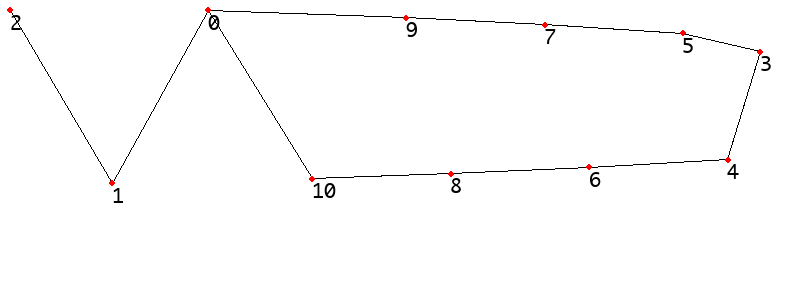

In [5]:
points = [
    [0.0, 0.0],                                #  0
    [-48.25806499350447, 87.58515378237739],   #  1
    [-100.0, 0.0],                             #  2
    [278.6114863027456, 20.99050464871304],    #  3
    [262.3556062275327, 75.61730109106234],    #  4
    [239.70656668920972, 11.694955721172022],  #  5
    [192.46145454090077, 79.46536034295708],   #  6
    [169.83252889374543, 7.497475267610899],   #  7
    [122.53231758155182, 82.6142973255933],    #  8
    [99.9200106660978, 3.998933418663416],     #  9
    [52.57518820490763, 85.06379714789684],    # 10
]
ps = Pointset(points=points)
# ps.add_before_edge([0, 9])
# ps.add_before_edge([1, 10])
ps.add_before_edge([1, 2])
# ps.add_before_edge([9, 10])
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=800)

In [6]:
ps.find_diameter()

[2, 3]

Pointset is NOT convex
b''
N = 22
Planarity: PLANAR
Max degree: 4
Stretch: 3.45837



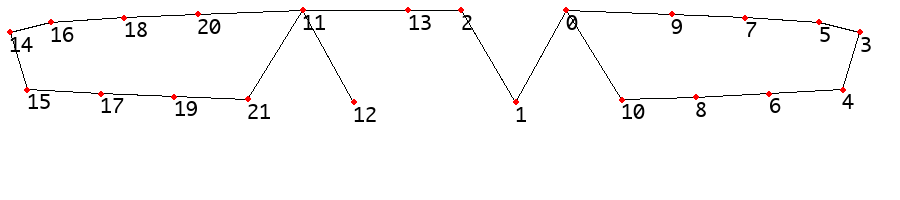

In [7]:
extra_points = [shift(scale(refY(p), 1/1.002), x=-250) for p in points]
ps = Pointset(points=points+extra_points)
ps.add_before_edge([1, 2])
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=900, img_h=200)
# Note: Talk in thesis about number of degree 4 vertices.

#### Short note
Though the above pointset is not convex, I believe it is possible to tweak it slightly in order to make it so, while maintaining this topology. It means that PathGreedy-5.19 on convex pointsets can have two degree-4 vertices.

Pointset is NOT convex
b''
N = 12
Planarity: PLANAR
Max degree: 3
Stretch: 3.41421



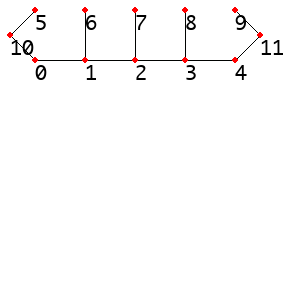

In [8]:
points_rectangle = [
    [0, 1], # 0
    [1, 1], # 1
    [2, 1], # 2
    [3, 1], # 3
    [4, 1], # 4
    [0, 0], # 5
    [1, 0], # 6
    [2, 0], # 7
    [3, 0], # 8
    [4, 0], # 9
    [-.5, .5],
    [4.5, .5],
]
ps = Pointset(points=points_rectangle)
draw_pathgreedy_from_pointset(ps, t=PAPER_T)

### Trying to build a degree-3 using only the lower hull

diameter: [0, 1]
Pointset is convex
b''
N = 6
Planarity: PLANAR
Max degree: 3
Stretch: 1.10931



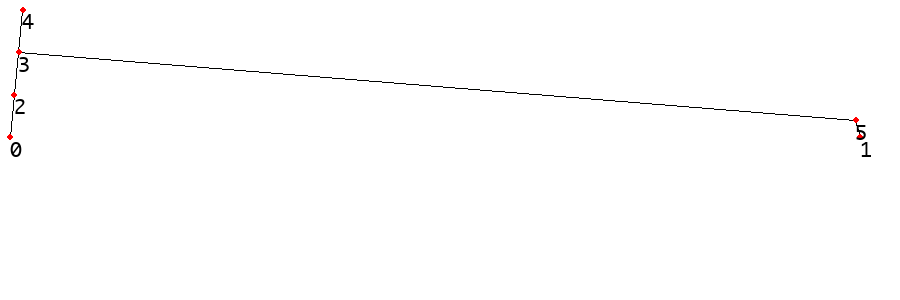

In [9]:
P = np.array([-100, 0])
Q = np.array([+100, 0])
# trying it simple first -- can shift by epsilon later
# A = np.array([99, 1])
A = np.array([-99, -10])
# B = np.array([-98, 2])
temp_b = np.array([-98, -20])
B = point_rotation(0.001, temp_b, A)
# C = np.array([-97, 3])
temp_c = np.array([-97, -30])
C = point_rotation(0.005, temp_c, B)
temp_d = point_rotation(PI/2, C, B)
temp_d = (temp_d-B)*19.5 + B
# D = point_rotation(0, temp_d, B)
D = [99, -4]
ps = Pointset(points=[P, Q, A, B, C, D])
print('diameter:', ps.find_diameter())
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=900, img_h=300)

In [10]:
D, ps.find_diameter()

([99, -4], [0, 1])

#### it worked!!!
time to try to use both upper and lower hull using reflection around the origin

Pointset is convex
b''
N = 10
Planarity: PLANAR
Max degree: 3
Stretch: 1.29579



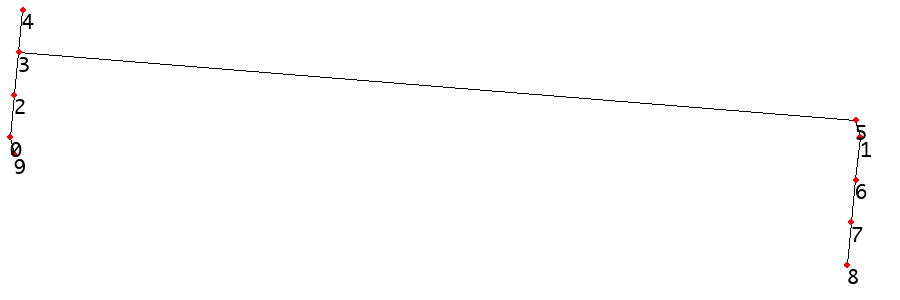

In [11]:
Aref = point_rotation(PI, A)
Bref = point_rotation(PI, B)
Cref = point_rotation(PI, C)
Dref = point_rotation(PI, D)
ps = Pointset(points=[P, Q, A, B, C, D, Aref, Bref, Cref, Dref])
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=900, img_h=300)
# this is nothing interesting

In [12]:
ps.find_diameter()

[4, 8]

#### Trying something new

diameter: [0, 1]
D coordinates: [99.94757664  0.99762253]
Pointset is convex
b''
N = 6
Planarity: PLANAR
Max degree: 2
Stretch: 1.10622



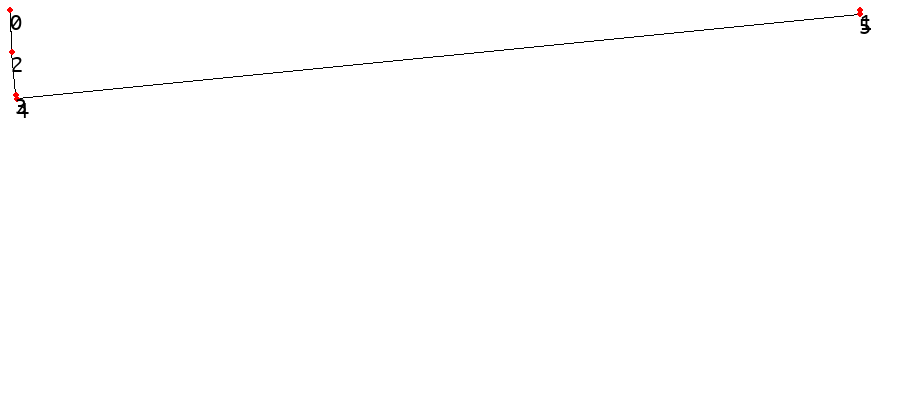

In [13]:
angle_eps = .05
shrink_eps = .001
P = np.array([-100, 0])
Q = np.array([+100, 0])
A = scale_vector(Q, point_rotation(-angle_eps, P, Q), 1-shrink_eps)
B = scale_vector(Q, point_rotation(-angle_eps, A, Q), 1-shrink_eps)
C = scale_vector(Q, point_rotation(-angle_eps*.1, B, Q), 1-shrink_eps)
D = point_rotation(angle_eps, scale_vector(Q, point_rotation(angle_eps/10, Q, P), 1-shrink_eps), Q)
ps = Pointset(points=[P, Q, A, B, C, D,])
print('diameter:', ps.find_diameter())
print('D coordinates:', D)
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=900, img_h=400)

In [14]:
angle_between(B, C, D)

1.7707395350967459

In [15]:
### another attempt

diameter: [0, 1]
Pointset is convex
b''
N = 9
Planarity: PLANAR
Max degree: 3
Stretch: 1.25183



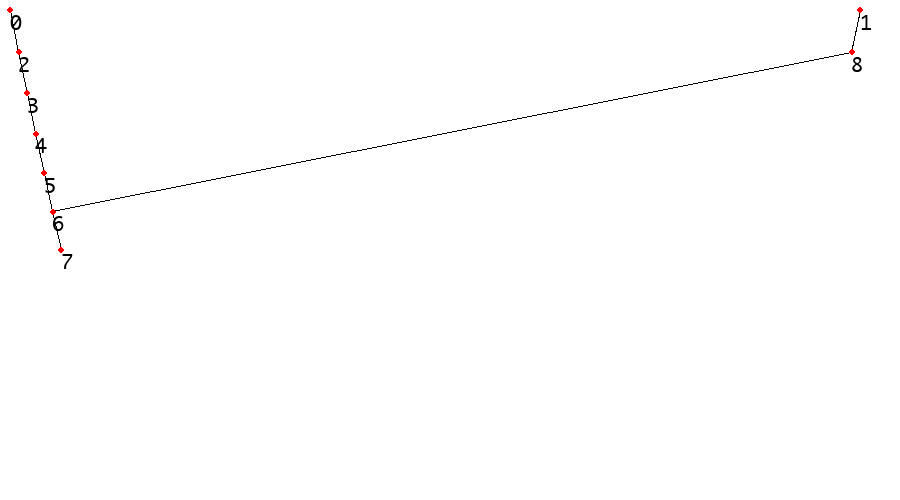

In [16]:
step = 10
P = np.array([-100, 0])
Q = np.array([+100, 0])
L1 = scale_vector(Q, np.array([-100, 1*step]), .99)
L2 = scale_vector(Q, np.array([-100, 2*step]), .98)
L3 = scale_vector(Q, np.array([-100, 3*step]), .97)
L4 = scale_vector(Q, np.array([-100, 4*step]), .96)
L5 = scale_vector(Q, np.array([-100, 5*step]), .95)
L6 = scale_vector(Q, np.array([-100, 6*step]), .94)
L7 = scale_vector(Q, np.array([-100, 7*step]), .93)
L8 = scale_vector(Q, np.array([-100, 8*step]), .92)
L9 = scale_vector(Q, np.array([-100, 9*step]), .89)
L10 = scale_vector(Q, np.array([-100, 10*step]), .87)
L11 = scale_vector(Q, np.array([-100, 11*step]), .85)
R1 = scale_vector(P, np.array([+100, 1*step]), .99)
R2 = scale_vector(P, np.array([+100, 2*step]), .98)
R3 = scale_vector(P, np.array([+100, 3*step]), .97)
R4 = scale_vector(P, np.array([+100, 4*step]), .96)
R5 = scale_vector(P, np.array([+100, 5*step]), .95)
# ps = Pointset(points=[P, Q, L1, L2, L3, L4, L5, L6, L7, L8, R1, R2, L9, L10, L11, R3, R4, R5])
# ps = Pointset(points=[P, Q, R1, R2, L9, L10, L11, R3])
ps = Pointset(points=[P, Q, L1, L2, L3, L4, L5, L6, R1])
print('diameter:', ps.find_diameter())
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=900, img_h=500)

In [17]:
point_distance(L1, Q)

198.24734550555777

In [18]:
x = "Hello world"
x

'Hello world'

## Planarity counter example

In [19]:
p = dict()

In [20]:
p[0] = np.array([0, 0])
p[1] = np.array([100.00001, 0])
p[2] = scale_vector(p[0], point_rotation(-PI/3, p[1], p[0]), .99999)
p[3] = scale_vector(p[0], point_rotation(-PI/3, p[2], p[0]), 1.000001)

In [21]:
#  building right purple path, connecting 2 and 1. This seems to work
eps = .0001
p[4] = scale_vector(p[2], point_rotation(PI+eps, p[3], p[2]), .9)
p[5] = scale_vector(p[4], point_rotation(PI+eps, p[2], p[4]), .8)
# ..
p[6] = scale_vector(p[1], point_rotation(PI-eps, p[0], p[1]), .9)
p[7] = scale_vector(p[6], point_rotation(PI-0.3, p[1], p[6]), .7)
# ..
p[8] = scale_vector(p[5], point_rotation(PI+0.4, p[4], p[5]), .5)

In [22]:
# building left purple path, connecting 3 to 0
eps = .0001
p[9]  = scale_vector(p[3], point_rotation(PI-eps, p[2], p[3]), .8)
p[10] = scale_vector(p[9], point_rotation(PI-eps, p[3], p[9]), .7)
# ..
p[11] = scale_vector(p[0], point_rotation(PI+eps, p[1], p[0]), .9)
p[12] = scale_vector(p[11], point_rotation(PI+0.1, p[0], p[11]), .8)
# ..
p[13] = scale_vector(p[10], point_rotation(PI-0.7, p[9], p[10]), .5)

Pointset is convex
b''
N = 14
Planarity: PLANAR
Max degree: 3
Stretch: 2



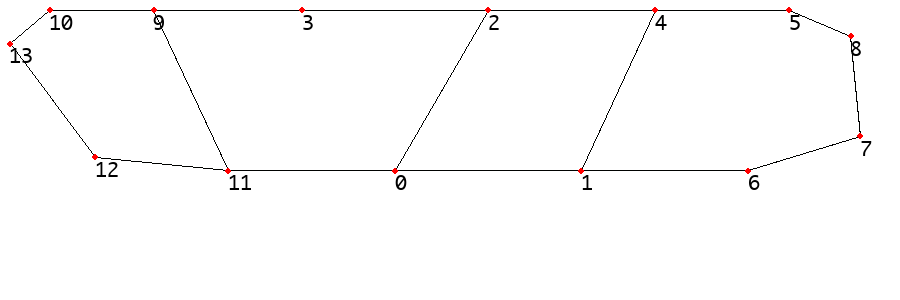

In [23]:
points = [p[i] for i in range(len(p))]
#ps = Pointset(points=points)
#ps = Pointset(points=points)
ps = Pointset(file_path='../pointsets/hand/example_not_plane.txt')
#ps.add_before_edge([3, 2])
draw_pathgreedy_from_pointset(ps, t=2, img_w=900, img_h=300)

In [24]:
right_purple_path = point_distance(p[2], p[4]) +\
                    point_distance(p[4], p[5]) +\
                    point_distance(p[5], p[8]) +\
                    point_distance(p[8], p[7]) +\
                    point_distance(p[7], p[6]) +\
                    point_distance(p[6], p[1])
right_purple_path

405.15214508141923

In [25]:
left_purple_path = point_distance(p[3], p[9])   +\
                   point_distance(p[9], p[10])  +\
                   point_distance(p[10], p[13]) +\
                   point_distance(p[13], p[12]) +\
                   point_distance(p[12], p[11]) +\
                   point_distance(p[11], p[0])
left_purple_path

402.53004054106907

In [26]:
ps.print_all()

14 0 0
0.0 0.0
100.00001 0.0
49.99950499995002 -86.60168301320752
-49.99955499945497 -86.60176961489056
139.9986585416246 -86.59260515630822
211.9979802887391 -86.57814293855375
190.00001854999996 -0.009000000885030014
250.18436130511697 -18.63279340971119
245.15304779027247 -72.5525543851693
-129.9988026059109 -86.59383897144998
-185.99827509528762 -86.5826875737462
-90.00000854999996 -0.00900000088500797
-161.63959645517573 -7.204170713011671
-207.41006264424473 -68.54049771722218



In [27]:
for i, point in enumerate(ps.points):
    print('\\fill[fill=black] (%.3f, %.3f) circle (0.2cm) node[anchor=north] {$%d$};' % (point[0]/10, point[1]/10, i))

\fill[fill=black] (0.000, 0.000) circle (0.2cm) node[anchor=north] {$0$};
\fill[fill=black] (10.000, 0.000) circle (0.2cm) node[anchor=north] {$1$};
\fill[fill=black] (5.000, -8.660) circle (0.2cm) node[anchor=north] {$2$};
\fill[fill=black] (-5.000, -8.660) circle (0.2cm) node[anchor=north] {$3$};
\fill[fill=black] (14.000, -8.659) circle (0.2cm) node[anchor=north] {$4$};
\fill[fill=black] (21.200, -8.658) circle (0.2cm) node[anchor=north] {$5$};
\fill[fill=black] (19.000, -0.001) circle (0.2cm) node[anchor=north] {$6$};
\fill[fill=black] (25.018, -1.863) circle (0.2cm) node[anchor=north] {$7$};
\fill[fill=black] (24.515, -7.255) circle (0.2cm) node[anchor=north] {$8$};
\fill[fill=black] (-13.000, -8.659) circle (0.2cm) node[anchor=north] {$9$};
\fill[fill=black] (-18.600, -8.658) circle (0.2cm) node[anchor=north] {$10$};
\fill[fill=black] (-9.000, -0.001) circle (0.2cm) node[anchor=north] {$11$};
\fill[fill=black] (-16.164, -0.720) circle (0.2cm) node[anchor=north] {$12$};
\fill[fill

In [28]:
print('pp = dict()')
for i, point in enumerate(ps.points):
    print('pp[%d] = np.array([%.3f, %.3f])' % (i, point[0]/10, point[1]/10))

pp = dict()
pp[0] = np.array([0.000, 0.000])
pp[1] = np.array([10.000, 0.000])
pp[2] = np.array([5.000, -8.660])
pp[3] = np.array([-5.000, -8.660])
pp[4] = np.array([14.000, -8.659])
pp[5] = np.array([21.200, -8.658])
pp[6] = np.array([19.000, -0.001])
pp[7] = np.array([25.018, -1.863])
pp[8] = np.array([24.515, -7.255])
pp[9] = np.array([-13.000, -8.659])
pp[10] = np.array([-18.600, -8.658])
pp[11] = np.array([-9.000, -0.001])
pp[12] = np.array([-16.164, -0.720])
pp[13] = np.array([-20.741, -6.854])


In [29]:
pp = dict()
pp[0] = np.array([0.000, 0.000])
pp[1] = np.array([10.000, 0.000])
pp[2] = np.array([5.000, -8.660])
pp[3] = np.array([-5.000, -8.660])
pp[4] = np.array([14.000, -8.659])
pp[5] = np.array([21.200, -8.658])
pp[6] = np.array([19.000, -0.001])
pp[7] = np.array([25.018, -1.863])
pp[8] = np.array([24.515, -7.255])
pp[9] = np.array([-13.000, -8.659])
pp[10] = np.array([-18.600, -8.658])
pp[11] = np.array([-9.000, -0.001])
pp[12] = np.array([-16.164, -0.720])
pp[13] = np.array([-20.741, -6.854])

Pointset is convex
b''
N = 14
Planarity: NOT PLANAR
Max degree: 2
Stretch: 5.05143



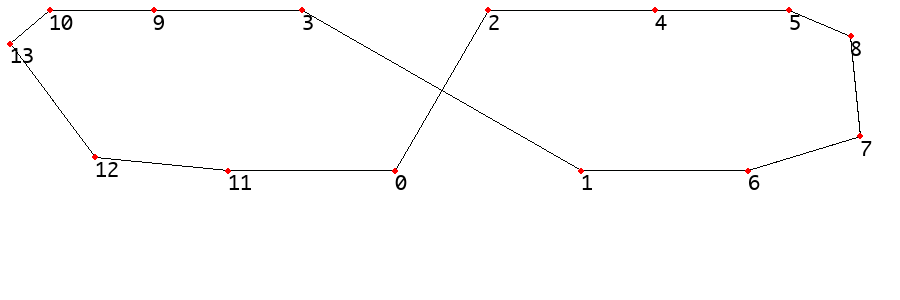

In [30]:
ps = Pointset(points=pp, is_dict=True)
draw_pathgreedy_from_pointset(ps, t=PAPER_T, img_w=900, img_h=300)

In [ ]:
pp = {}
pp = [1, 0]